In [223]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
import cvxpy as cp
from scipy.optimize import fsolve

In [224]:
M=2000
ite=9
dim_n=3
T=1
delta = torch.tensor(T/ite)
kappa=0.4
eta=1/500
nu=0.0001
rho=0
alpa=0.5
neuron_model_psi=20

In [225]:
model= torch.nn.Sequential(
    torch.nn.Linear(dim_n, neuron_model_psi),
    #torch.nn.BatchNorm1d(num_features=neuron_model_psi),
    torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi, neuron_model_psi),
    #torch.nn.BatchNorm1d(num_features=neuron_model_psi),
    # torch.nn.ReLU(),
    # torch.nn.Linear(neuron_model_psi, neuron_model_psi_2),
    # torch.nn.ReLU(),
    # torch.nn.Linear(neuron_model_psi_2, neuron_model_psi),
    torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi,1)
)

In [226]:
t=torch.zeros([M,1])
D=torch.zeros([M,1])
#D=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
R=torch.FloatTensor(M,1).uniform_(100000,100500)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
x=torch.cat((t,D,R),dim=1)
# print(x)
# print(x.shape)

In [227]:
def update(x3,psi):
  t=(x3[:,0]+(1/ite))
  #print(psi.squeeze(1).shape,x1[:,1].shape)
  #D = (x3[:,1]+kappa*psi)*torch.exp(-rho*delta)
  #D = (1-kappa)*x3[:,1]+eta*torch.pow(torch.abs(psi),alpa)*torch.sign(psi)
  D = (1-kappa)*x3[:,1]+eta*torch.pow(torch.abs(psi),alpa)
  R= x3[:,2]-psi
  #print(R.shape)
  up=torch.cat((t.unsqueeze(1),D.unsqueeze(1),R.unsqueeze(1)),dim=1)
  #print('up shape=', up.shape)
  return up

def loss_func(x2,psi):
  #loss=(x2[:,1]*psi+(kappa/2.0)*torch.pow(psi,2))
  #loss=((1-kappa)*x2[:,1]+(eta/2.0)*torch.pow(torch.abs(psi),alpa)*torch.sign(psi))*psi+nu*torch.pow(x2[:,2]-psi,2)
  loss=(1-kappa)*x2[:,1]*psi+(eta/2.0)*torch.pow(torch.abs(psi),alpa+1)+nu*torch.pow(x2[:,2]-psi,2)
  return loss

def unit(x1,model):
    psi=model(x1).squeeze(1)
    # psi=torch.maximum(psi,torch.zeros(psi.shape))
    # psi=torch.minimum(psi,x1[:,2])
    los=loss_func(x1,psi)
    upd=update(x1,psi)
    #print('unit print=',psi.shape,los.shape,upd.shape)
    return psi,los,upd

def loss_func_total(u,model):
  loss=torch.zeros(M,ite)
  psi=torch.zeros(M,ite)
  for i in range(ite+1):
    if(i!=ite):
      psi_run,loss_run,u_run=unit(u,model)
      #print('los func=',psi_run.shape,loss_run.shape)
      loss[:,i]=loss_run
      #print(loss)
      psi[:,i]=psi_run
      #print(psi)
      u=u_run
      #print(u)
    else:
      #print(torch.sum(psi,dim=1),R.squeeze(1))
      psi_ter=R.squeeze(1)-torch.sum(psi,dim=1)
      # loss_ter=loss_func(u,psi_ter)
      loss_ter=(1-kappa)*u[:,1]*psi_ter+(eta/2.0)*torch.pow(torch.abs(psi_ter),alpa+1)

      #print('ter',loss_ter.shape)
  #print(torch.sum(loss,dim=1))
  loss=torch.sum(loss,dim=1)+loss_ter
  #print(loss.shape)
  return torch.mean(loss)

Training

In [ ]:
lr1 = 8e-2
max_epoch = 3000
optimizer = optim.Adam(model.parameters(), lr1)

#print(psi.shape)
for epoch in range(max_epoch):
  optimizer.zero_grad()
  cost=loss_func_total(x,model)
  cost.backward()
  optimizer.step()
  #print(loss.item())
  if (epoch % 100==0):
    print("At epoch {} the cost is {}.".format(epoch,cost.detach()))

At epoch 0 the cost is 9774217.0.
At epoch 100 the cost is 31726.63671875.
At epoch 200 the cost is 31725.677734375.
At epoch 300 the cost is 31723.802734375.
At epoch 400 the cost is 31721.67578125.
At epoch 500 the cost is 31719.384765625.
At epoch 600 the cost is 31717.009765625.
At epoch 700 the cost is 31714.5859375.
At epoch 800 the cost is 31712.52734375.
At epoch 900 the cost is 31710.751953125.
At epoch 1000 the cost is 31766.978515625.
At epoch 1100 the cost is 31718.482421875.
At epoch 1200 the cost is 31717.5625.
At epoch 1300 the cost is 31716.849609375.
At epoch 1400 the cost is 31716.109375.
At epoch 1500 the cost is 31715.345703125.
At epoch 1600 the cost is 31714.552734375.
At epoch 1700 the cost is 31713.732421875.
At epoch 1800 the cost is 31712.876953125.
At epoch 1900 the cost is 31711.9921875.
At epoch 2000 the cost is 31711.080078125.
At epoch 2100 the cost is 31710.13671875.
At epoch 2200 the cost is 31709.1640625.
At epoch 2300 the cost is 31708.1640625.
At epo

Solution by using cvxpy package

In [ ]:
def numeric_soln(X,n):
    delt=T/n
    alpha=math.exp(-delt*rho)
    c=np.ones(n)
    x=cp.Variable(n)
    #objective=cp.Minimize(determinstic_main(x))
    A=[[0 for i in range(n)] for j in range(n)]
    for i in range(n):
        for j in range(n):
            A[i][j]=1-kappa+kappa*pow(alpha,abs(i-j))
    constraints=[0<=x,sum(x)==X]

    objective=cp.Minimize(1/2*cp.quad_form(x,A))
    prob=cp.Problem(objective,constraints)
    #print("prob is DCP:", prob.is_dcp())
    #print("curvature of objective:",cp.sum(pow(x,2)).curvature)
    #assert prob.is_dqcp()
    cost=prob.solve()
    #print("Optimal value", prob.solve())
    #print("Optimal value", prob.solve(qcp=True))
    #print("Optimal soln")
    soln=x.value
    #print(soln) # A numpy ndarray
    return soln,cost

Colsed form soln


In [ ]:
def closed_form(X):
  alpha=np.exp(-rho*T/ite)
  p=np.zeros(ite+1)
  p[0]=X/(2+(ite-2)*kappa)
  p[ite]=X/(2+(ite-2)*kappa)
  for j in range(1,ite):
    p[j]=p[0]*kappa
  return p


**Calculating cost** predicted and closed cost both have the same function. I wrote it twice because of two different data type

In [ ]:
def predicted_cost(psi):
  cost=0.0
  D=0.0

  for i in range(ite+1):
    #print(D)
    cost+=D*psi[i]+(kappa/2.0)*torch.pow(psi[i],2)
    D=(D+kappa*psi[i])*torch.exp(-rho*delta)
  return cost

def closed_cost(y):
  cost1=0.0
  D1=0.0

  for i in range(ite+1):
    cost1+=D1*y[i]+(kappa/2.0)*np.power(y[i],2)
    D1=(D1+kappa*y[i])*np.exp(-rho*T/ite)
  return cost1

**Testing ** We have compared the closed form solution from Obhizaeva and Wang, our predicted solution and the numerical solution from python convex optimization package cvxpy

In [ ]:
from torch.nn.modules.pooling import MaxPool1d
M1=10
t_test=torch.zeros([M1,1])
D_test=torch.zeros([M1,1])
#D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
#R_test=torch.FloatTensor(M1,1).uniform_(50,100)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
R_test=torch.linspace(100000,100500, steps=M1).unsqueeze(1)
x_test=torch.cat((t_test,D_test,R_test),dim=1)
#print('Input=',x_test,'\n')
a=torch.zeros(M1,ite+1)
#print(a.shape)
for i in range(ite+1):
  if(i!=ite):
    #print(x_test)
    soln_pred=model(x_test).squeeze(1).detach()
    a[:,i]=soln_pred
    x_test=update(x_test,soln_pred)
    #print(x_test,'\n')
  else:
    a[:,i]=R_test.squeeze(1)-torch.sum(a,dim=1)

x1=R_test.squeeze().numpy()
c_true=np.zeros(M1)
c_pred=np.zeros(M1)
c_num=np.zeros(M1)
n_soln=np.zeros((M1,ite+1))
t_soln=np.zeros((M1,ite+1))

for i in range(M1):
  print('size of total order=',x1[i])

  # num_soln,num_cost=numeric_soln(x1[i],ite+1)
  # n_soln[i,:]=num_soln
  # print('Numeric_soln',num_soln,'sum of all execution=',np.sum(num_soln))
  # print('Numeric_cost=',num_cost,'\n')
  # c_num[i]=num_cost

  # t_soln[i,:]=closed_form(x1[i])
  # print('closed form soln=',t_soln[i,:],'sum of all execution=',np.sum(t_soln[i,:]))
  # true_cost=closed_cost(t_soln[i,:])
  # c_true[i]=true_cost
  # print('Closed form cost=',true_cost,'\n')

  print('predicted soln=',a[i,:],'sum of all execution=',torch.sum(a[i,:]).detach())
  pred_cost=predicted_cost(a[i,:])
  print('predicted cost=',pred_cost.detach().numpy(),'\n')
  c_pred[i]=pred_cost

Comparing the cost

In [ ]:
print(x1.shape)
plt.figure()
# plt.plot(x1,c_true,color='blue',label='cost_closed_form')
# plt.plot(x1,c_num,color='green',label='cost_numerical')
plt.plot(x1,c_pred,color='red',label='cost_Neural Network')
plt.legend()
plt.show()

Comparing solution for diffeternt testing samples

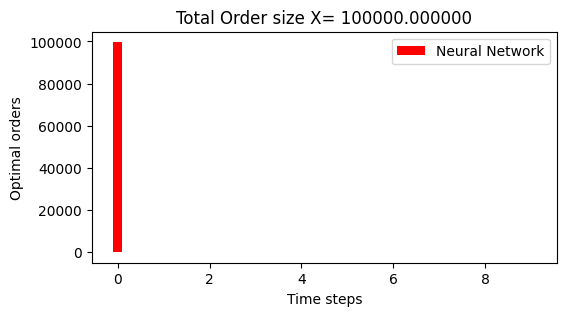

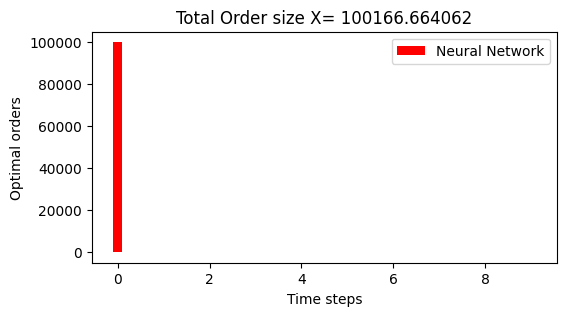

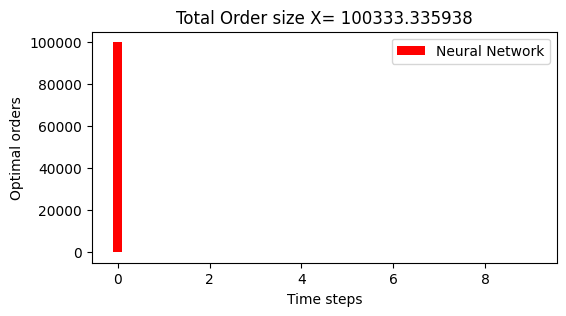

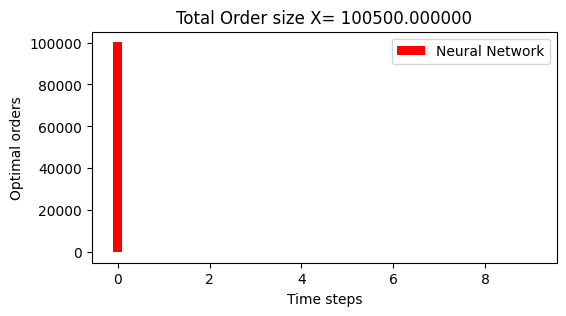

In [ ]:
p_soln=a.numpy()
t_step=np.linspace(0,ite,num=ite+1)
def plotting(t):
  #print('Total order size=',x1[t],np.sum(n_soln[t]),np.sum(p_soln[t]))
  #print(n_soln[t],p_soln[t])
  plt.figure(figsize=(6,3))
  # plt.bar(t_step,t_soln[t],color='blue',width=0.3,label='Closed form')
  # plt.bar(t_step,n_soln[t],color='green',width=0.1,label='numerical')
  plt.bar(t_step,p_soln[t],color='red',width=0.2,label='Neural Network')
  plt.title('Total Order size X= %f' % (x1[t]))
  plt.xlabel('Time steps')
  plt.ylabel('Optimal orders')
  plt.legend()
  plt.show

for i in range(0,M1,3):
  plotting(i)


Comparing solution at different time steps

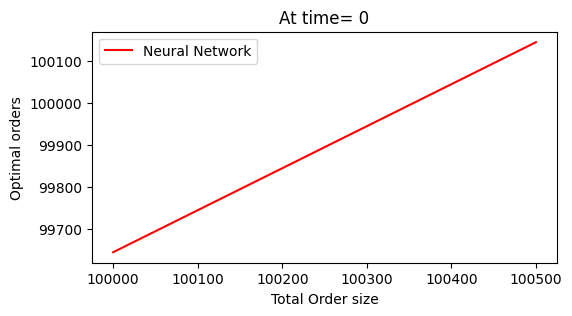

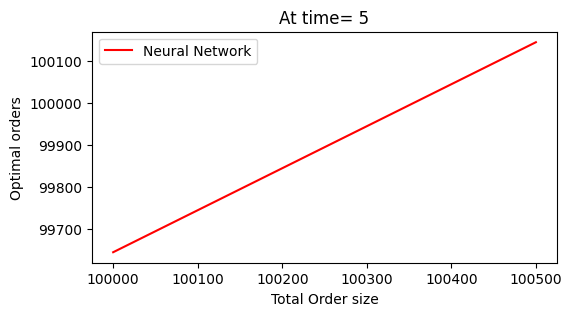

In [ ]:
#p_soln=a.numpy()
t_step=np.linspace(0,ite,num=ite+1)
X=R_test.squeeze(1).numpy()
def plotting_time(t):
  #print(t_soln[t],p_soln[t])
  plt.figure(figsize=(6,3))
  # plt.plot(X,t_soln[:,0],color='blue',label='Closed form')
  # plt.plot(X,n_soln[:,0],color='green',label='numerical')
  plt.plot(X,p_soln[:,0],color='red',label='Neural Network')
  plt.title('At time= %d' % (t_step[t]))
  plt.xlabel('Total Order size')
  plt.ylabel('Optimal orders')
  plt.legend()
  plt.show
for i in range(0,t_step.shape[0],5):
  plotting_time(i)


Absolute sum of the difference between true solution, predicted solution and true soln, numeric soln at each time step

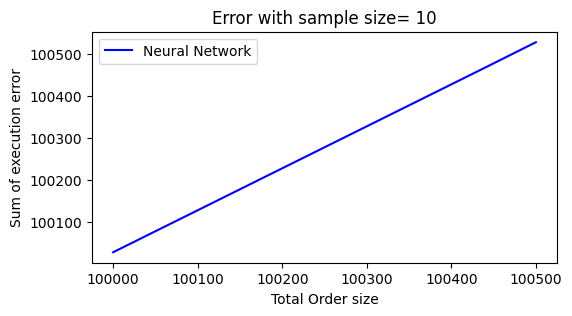

In [ ]:
sq_error=np.zeros(M1)
sq_error_num=np.zeros(M1)

for i in range(M1):
  sq_error[i]=np.sum(np.abs(t_soln[i]-p_soln[i]))
  sq_error_num[i]=np.sum(np.abs(t_soln[i]-n_soln[i]))

plt.figure(figsize=(6,3))
plt.plot(X,sq_error,color='blue',label='Neural Network')
#plt.plot(X,sq_error_num,color='green',label='numerical')
plt.title('Error with sample size= %d' % (M1))
plt.xlabel('Total Order size')
plt.ylabel('Sum of execution error')
plt.legend()

Additional rough test

In [ ]:
# from torch.nn.modules.pooling import MaxPool1d
# M1=100
# t_test=torch.zeros([M1,1])
# D_test=torch.zeros([M1,1])
# #D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
# R_test=torch.linspace(50,100,100).unsqueeze(1)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
# x_test=torch.cat((t_test,D_test,R_test),dim=1)
# #print('Input=',x_test,'\n')
# soln=[]
# x_update = x_test
# #print(x_update)
# for i in range(ite+1):
#     #print(x_update)
#     soln_pred=model(x_update)
#     #print(soln_pred)
#     x_udpate=update(x_update,soln_pred.squeeze(1))
#     #print(x_update)
#     soln.append(soln_pred)
# strategy = torch.cat(soln,dim=1)
# print(strategy)
# # print('predicted soln=',strategy,'sum of all execution=',torch.sum(strategy,dim=1),'\n')
# a=[]
# b=[]
# c=[]
# for x in R_test:
#     a.append(x.numpy()[0])
#     y=closed_form(x.numpy()[0],ite+1)
#     #print(y)
#     b.append(y[0][0])
#     c.append(y[1])